# Heatmap of sensor readings

In [24]:
from datetime import timedelta
import calendar

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp

from vast_2017_mc2 import load_cleaned_data

## Load

In [2]:
data = load_cleaned_data()
data.head(2)

reading  wind_direction  wind_speed_ms  \
chemical monitor timestamp                                                      
AGOC-3A  1       2016-08-09 13:00:00  0.346214       44.533333          0.567   
         2       2016-08-09 13:00:00  0.335259       44.533333          0.567   

                                      wind_speed_kmh  missing_sensor  \
chemical monitor timestamp                                             
AGOC-3A  1       2016-08-09 13:00:00            2.04               0   
         2       2016-08-09 13:00:00            2.04               0   

                                      has_duplicate  missing_wind       date  \
chemical monitor timestamp                                                     
AGOC-3A  1       2016-08-09 13:00:00              0             0 2016-08-09   
         2       2016-08-09 13:00:00              0             0 2016-08-09   

                                      hour  month hour_category  \
chemical monitor timestamp                                        
AGOC-3A  1       2016-08-09 13:00:00    13      8           day   
         2       2016-08-09 13:00:00    13      8           day   

                                     hour_subcategory  east_km  north_km  
chemical monitor timestamp                                                
AGOC-3A  1       2016-08-09 13:00:00        afternoon  5.98548   2.02734  
         2       2016-08-09 13:00:00        afternoon  6.37164   3.37890

## Heatmap

### Helpers

In [72]:
def dilated_image(img, x_dilation=1, y_dilation=1):
    dilations = [y_dilation, x_dilation]
    def mapped_ordinates(axis):
        return (np.linspace(0, img.shape[axis]-0.0001, int(dilations[axis] * img.shape[axis]))).astype(int)
    return img[np.meshgrid(mapped_ordinates(0), mapped_ordinates(1), indexing='ij')]

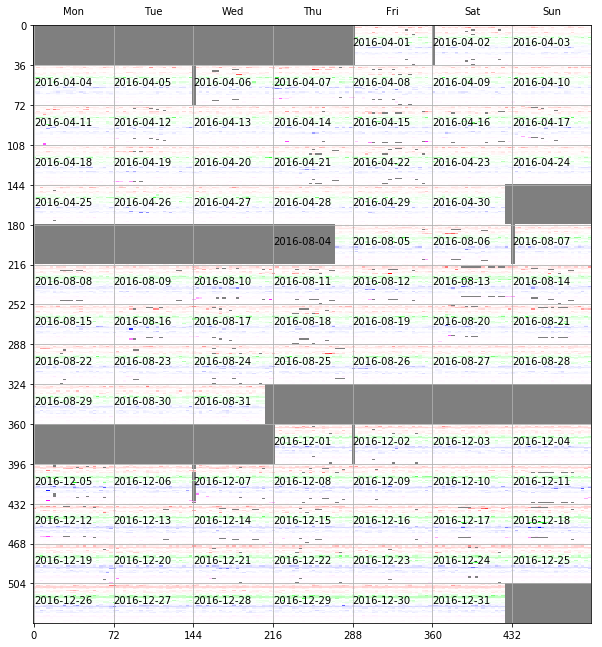

In [111]:
reading_info = data['reading'].copy().reset_index().rename(columns={'monitor':'sensor'})
reading_info['day_start_timestamp'] = pd.to_datetime(reading_info['timestamp'].dt.date)
chemical_info = pd.DataFrame({'chemical': reading_info['chemical'].unique()}).sort_values('chemical')
chemical_info['chem_ndx'] = np.arange(len(chemical_info))
chemical_info.set_index('chemical', inplace=True)
chem_colors = dict(zip(chemical_info.index, [[(1,1,1), t] for t in [(1,0,0), (0,1,0), (0,0,1), (1,0,1)]]))
week_end_day = 6
date_info = reading_info[['day_start_timestamp']].drop_duplicates().sort_values(by='day_start_timestamp')
date_info['week_number'] = np.cumsum(((date_info['day_start_timestamp'].dt.weekday + 7 - week_end_day) % 7 == 1)*1 + np.r_[0, (date_info['day_start_timestamp'] - date_info['day_start_timestamp'].shift(1) > timedelta(days=1)).iloc[1:]*1])
counts = {'weeks': date_info['week_number'].max()+1, 'chemicals': len(chemical_info), 'sensors': reading_info['sensor'].max(), 'hours':24, 'weekdays':7}
date_info['day_x'] = ((date_info['day_start_timestamp'].dt.weekday + (6 - week_end_day)) % 7) * counts['hours']
date_info['day_y'] = date_info['week_number'] * (counts['chemicals'] * counts['sensors']) 
date_info.set_index('day_start_timestamp', inplace=True)
reading_info = reading_info.join(date_info, on='day_start_timestamp').join(chemical_info, on='chemical')
reading_info['x'] = reading_info['day_x'] + reading_info['timestamp'].dt.hour
reading_info['y'] = reading_info['day_y'] + (reading_info['chem_ndx'] * counts['sensors']) + (reading_info['sensor'] - 1)
reading_info['scaled_reading'] = reading_info['reading'] / reading_info.groupby('chemical')['reading'].max()[reading_info['chemical']].values
raw_heatmap = np.full(fill_value=0.5, shape=(counts['weeks']*counts['chemicals']*counts['sensors'], counts['hours']*counts['weekdays'], 3))
for chem, p in chem_colors.items():
    rows = reading_info[reading_info['chemical'] == chem]
    if len(rows) > 0:
        palette = sns.color_palette(p)
        col_interp = sp.interpolate.interp1d(np.linspace(0, 1, len(palette)), np.array(palette), axis=0)
        raw_heatmap[rows['y'].values, rows['x'].values] = col_interp(rows['scaled_reading'].values)

plt.figure(figsize=(10,15))
x_dilation = 3
y_dilation = 1
plt.imshow(dilated_image(raw_heatmap, x_dilation=x_dilation, y_dilation=y_dilation))
ax = plt.gca()
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=counts['hours']*x_dilation))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=counts['sensors']*counts['chemicals']*y_dilation))
ax.grid(which='major', axis='both', linestyle='-')
days = list(calendar.day_abbr)
for ndx, day in enumerate(days[:week_end_day+1]+days[week_end_day+1:]):
    plt.text((ndx+0.5) * counts['hours'] * x_dilation, -10, day, ha='center')
    
date_info['date'] = date_info.reset_index()['day_start_timestamp'].dt.date.values
for _, row in date_info.iterrows():
    plt.text(row['day_x'] * x_dilation, row['day_y'] + 18 , row['date'])
plt.show()